# <font size = "10" color = "red"> SAC training - Compact Boson

## <font size = "6"> Packages

In [1]:
#!pip install stable-baselines3
import gym
import math
import numpy as np
from numpy import array, inf, vectorize, repeat, power
from numpy import abs as np_abs
from numpy import sum as np_sum
#from scipy.special import hyp2f1
import mpmath as mp
from mpmath import fp, hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import zeros, zeros_like
from numpy import ones, ones_like
from numpy import inf
from numpy import minimum, maximum
import matplotlib.pyplot as plt
import os
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3 import SAC
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from itertools import zip_longest
import CFT_Env_Scipy as CFT_Env
import pandas as pd

## <font size = "6">Environment Setup

Main modifications:

-Introduced guess mode:
When in guess mode the environment is reset to a random state. When in normal mode the environment is reset to the best state so far.

-Agent trapped:
Introduced a control that terminates the episode if the agent has taken too many steps without improvement.

-Min reward capped:
When the rewards get smaller than a big multiple of the best reward the episode is terminated. This should avoid divergencies in the loss. 

-Mode 2 training:
Freeze scaling dimensions at the beginning of the training. 

-NEW: THE STATE FED TO THE NETWORK IS THE 10 DIMENSIONAL ONE INCLUDING SCALING DIMENSIONS AND OPE COEFFICIENTS, NOT THE ERRORS OF THE 29 CROSSING EQUATION


The definition of $E_{abs}$ for the Ising model seems to be closer to:

\begin{equation}
E_{abs} = \sum_{i=1}^{N_z} \left[ \left| 1-z_i \right|^{2\Delta}\sum_{h, \bar{h}}\vphantom{\sum}^{\prime} \left| C_{h,\bar{h}}^{(s)}g_{h,\bar{h}}^{(s)}(z_i, \bar{z}_i)\right| + \left| z_i \right|^{2\Delta}\sum_{h, \bar{h}}\vphantom{\sum}^{\prime} \left| C_{h,\bar{h}}^{(t)}g_{h,\bar{h}}^{(t)}(1 - z_i, 1 - \bar{z}_i)\right| + \left| 1-z_i \right|^{2\Delta} + \left|z_i \right|^{2\Delta}\right]
\end{equation}

### <font color = "red">General CFT Environment: Examples

#### <font color = "orange" size = "3">Examples 1: Analytic Ising

In [2]:
spec_Ising_analytic = {
    0: [{'Delta': 4, 'C': 2.44141e-4}, {'Delta': 1, 'C': 0.25}],
    2: [{'Delta': 2, 'C': 0.015625}],
    4: [{'Delta': 4, 'C': 2.19727e-4}],
    6: [{'Delta': 6, 'C': 1.36239e-5}],
}


Ising = CFT_Env.CFT_Env(spec_Ising_analytic, spec_Ising_analytic, Del_Ext = 1/8, s_is_t = True)
print(Ising.full_del_c_spec_flat)
print(Ising.full_spin_spec_flat)
print( Ising.Reward(rand(29, 2)) )
print( Ising.Accuracy(rand(29, 2)) )

[4.00000e+00 2.44141e-04 1.00000e+00 2.50000e-01 2.00000e+00 1.56250e-02
 4.00000e+00 2.19727e-04 6.00000e+00 1.36239e-05]
[0 0 2 4 6]
-0.02709009852789215
0.002089701375719303


In [3]:
Ising.Full_Spec_List_to_Spec_Dict()
ising_action = array([i**2 for i in range(10)])
Ising.Update_Spec(ising_action)
print(Ising.full_del_c_spec_flat)

[ 4.          1.00024414  5.          9.25       18.         25.015625
 40.         49.00021973 70.         81.00001362]


#### <font color = "orange" size = "3">Examples 2 - 1: Analytic Compact boson 1

In [4]:
spec_s_1_analytic = { 
    0: [{'Delta': 0.4, 'C': 1}], 
    }
spec_t_1_analytic = { 
    0: [{'Delta': 2, 'C': 1e-2}], 
    1: [{'Delta': 1, 'C': -0.1}],
    2: [{'Delta': 2, 'C': 5e-3}],
    }

Compact_Boson_1 = CFT_Env.CFT_Env(spec_s_1_analytic, spec_t_1_analytic, Del_Ext = 0.1, s_Id = 0)
print( Compact_Boson_1.full_del_c_spec_flat )
print( Compact_Boson_1.full_spin_spec_flat )
print( Compact_Boson_1.Reward(rand(30, 2)) )
print( Compact_Boson_1.Accuracy(rand(30, 2)) )

[ 0.4    1.     2.     0.01   1.    -0.1    2.     0.005]
[0 0 1 2]
-0.10695052090485883
0.001724228386039909


In [5]:
Compact_Boson_1.Full_Spec_List_to_Spec_Dict()

({0: [{'Delta': 0.4, 'C': 1.0}]},
 {0: [{'Delta': 2.0, 'C': 0.01}],
  1: [{'Delta': 1.0, 'C': -0.1}],
  2: [{'Delta': 2.0, 'C': 0.005}]})

#### <font color = "orange" size = "3">Examples 2 - 2: Analytic Compact boson 2

In [6]:
spec_s_2_analytic = { 
    0: [{'Delta': 0.4, 'C': 1}], 
    2: [{'Delta': 2.4, 'C': 3.57143e-3}],
    3: [{'Delta': 3.4, 'C': 0}]
    }
spec_t_2_analytic = { 
    0: [{'Delta': 2, 'C': 1e-2}], 
    1: [{'Delta': 1, 'C': -0.1}, {'Delta': 3, 'C': -5e-4}],
    2: [{'Delta': 2, 'C': 5e-3}],
    3: [{'Delta': 3, 'C': -1.66667e-4}]
    }

Compact_Boson_2 = CFT_Env.CFT_Env(spec_s_2_analytic, spec_t_2_analytic, Del_Ext = 0.1, s_Id = 0)
print( Compact_Boson_2.full_del_c_spec_flat )
print( Compact_Boson_2.full_spin_spec_flat )
print( Compact_Boson_2.Reward(rand(30, 2)) )
print( Compact_Boson_2.Accuracy(rand(30, 2)) )

[ 4.00000e-01  1.00000e+00  2.40000e+00  3.57143e-03  3.40000e+00
  0.00000e+00  2.00000e+00  1.00000e-02  1.00000e+00 -1.00000e-01
  3.00000e+00 -5.00000e-04  2.00000e+00  5.00000e-03  3.00000e+00
 -1.66667e-04]
[0 2 3 0 1 1 2 3]
-0.026618773037776797
0.0006993846310836837


In [7]:
Compact_Boson_2.Full_Spec_List_to_Spec_Dict()

({0: [{'Delta': 0.4, 'C': 1.0}],
  2: [{'Delta': 2.4, 'C': 0.00357143}],
  3: [{'Delta': 3.4, 'C': 0.0}]},
 {0: [{'Delta': 2.0, 'C': 0.01}],
  1: [{'Delta': 1.0, 'C': -0.1}, {'Delta': 3.0, 'C': -0.0005}],
  2: [{'Delta': 2.0, 'C': 0.005}],
  3: [{'Delta': 3.0, 'C': -0.000166667}]})

## <font size = "6">Training

### <font color = "red">Training Environment

In [8]:
class Training_Env_New(gym.Env):
    """
    Creates a general training environment that can be used with different CFTs.
    The input to the Network are the states, not the errors for the crossing equations.
    """     
    def __init__(
                 self, Model, sampled_points,
                 min_state_bound = None, max_state_bound = None,
                 guess_mode_steps = 0, trapped_steps = 100, reward_cap = 100, reward_scale = 1.,
                 guess_size = 6.5, freeze_mask = None, freeze_accuracy = 0.001
                 ):
        """
        Args:
        error_fn:        function for the crossing equations to be used for penalty.
                         Given a state as input should return ||E||.
        accuracy_fn:     function used to compute accuracy. Given a state should return ||E||/E_{abs}
        state_dim:       integer. dimension of the array of variables to be searched.
        initial state:   array of dimension state_dim. Initial values for the variables to be searched.
        min_state_bound: float or array of dimension state_dim. Sets the minimum value for the search of variables. 
                         If a float, the bound is common for all variables.
        max_state_bound: float or array of dimension state_dim. Sets the maximum value for the search of variables. 
                         If a float, the bound is common for all variables.
        gues_mode_steps: integer. Number of steps to be taken in guess mode.
        trapped_steps:   integer. Number of steps without improvement on the best state after which the environment is reset. 
        reward_cap:      float. Resets the environment when the agent finds a state with reward<reward_cap*best_reward. Should increase stability.
        reward_scale:    float. Reward is computed as -reward_scale*||E||
        guess_size:      float or array of dimension state_dim. Sets the search window at each step for the variables.
                         If a float, the guess size is the same for all variables.
        freeze_mask:     array of dimension state_dim containing only 0 and 1. The variables corresponding to indices that are 0 are not changed
                         until the accuracy reach the level freeze_accuracy. This is needed for training in mode 2. If None no variable is frozen,
        freeze_accuracy: float. Value of accuracy at which all the variables are unfrozen if freeze_mask is not None
        """
        self.Model = Model
        self.pts = sampled_points

        self.state_min = min_state_bound #Set minimum for the search window
        self.state_max = max_state_bound #Set maximum for the search window
        self.state_dim = self.Model.state_dim #state_dim
        self.best_reward = None  #Records best reward
        self.best_accuracy = None
        self.best_state = None   #Records best state
        self.scale = reward_scale #Scale the error
        self.guess_mode = True #Controls wheter the algorithm is working in guess mode
        self.guess_mode_steps = guess_mode_steps #Number of steps to take in guess mode
        self.step_counter = 0 #Records the number of steps executed in the environment
        self.not_improving_steps = 0 #Stores the number of steps since last improvement
        self.trapped_steps = trapped_steps #Maximum number of not improving steps after which the environment is reset
        self.current_reward = None  #Current reward for guess mode
        self.improv_hist = [] #Records reward when a new best state is found
        self.reward_cap = reward_cap #Reset the environment when reward>reward_cap*best_reward
        self.guess_size = guess_size #Search window for each parameter
        self.initial_state = self.Model.full_del_c_spec_flat
        #self.error_fn = error_fn
        #self.accuracy_fn = accuracy_fn
        
        #Setup freeze mode is a mask is passed
        if freeze_mask is not None:
                self.freeze_mode = True      
                self.freeze_mask = freeze_mask
                self.freeze_accuracy = freeze_accuracy
        else:
            self.freeze_mode = False    
        
        
        #Initialize action and observation spaces
        self.action_space = gym.spaces.Box(
            np.float32(array([-1. for i in range(self.state_dim)])), np.float32(array([1. for i in range(self.state_dim)]))
            )
        self.observation_space = gym.spaces.Box(
            np.float32(array([-inf for i in range(self.state_dim)])),np.float32(array([inf for i in range(self.state_dim)]))
            )
        
    def step(self, action):
        

        self.step_counter += 1 #Increase step counter 

        if self.guess_mode:
            current_reward = self.Model.Reward(self.pts) * self.scale
            
        if self.freeze_mode: #In freeze_mode freeze some of the parameters during training
            
            acc = self.Model.Accuracy(self.pts)

            if acc < self.freeze_accuracy and not self.guess_mode:
                self.freeze_mode = False

            action = action * self.freeze_mask
                
    
        #self.Model.Update_Spec(action * self.guess_size)

        self.state = self.state + action * self.guess_size
        #print(self.state)
        self.state = np.maximum(self.state_min, self.state)
        self.state = np.minimum(self.state_max, self.state)
        obs = self.state
        self.Model.Update_Spec_with_new_spec(self.state)
        reward = self.Model.Reward(self.pts) * self.scale
        accuracy =  self.Model.Accuracy(self.pts)

        if self.step_counter % 1000 == 0:
            print(f'Step:{self.step_counter}, Best_Reward:{self.best_reward:.6f}, Guess_Mode:{self.guess_mode}, Freeze_Mode:{self.freeze_mode}')
            print(self.best_state)
        
        if self.best_reward is None:
            self.best_reward = reward
            self.best_state = self.state

        if self.guess_mode:

            if self.step_counter > self.guess_mode_steps: #end guess_mode
                self.guess_mode = False
                done = True
            #check update best reward
            if reward > self.best_reward:
                self.best_reward = reward
                self.best_state = self.state
                self.improv_hist.append((self.step_counter, reward, accuracy, self.state))
                self.not_improving_steps = 0


            if reward > current_reward:
                done=True
            else:
                self.not_improving_steps+=1
                done=False

        else:
            #check update best reward and terminate
            if reward > self.best_reward:
                self.best_reward = reward
                self.best_state = self.state
                self.not_improving_steps = 0
                self.improv_hist.append((self.step_counter, reward, self.state))
                done = True
                
            else:
                self.not_improving_steps += 1
                done = False
                
            if reward < self.reward_cap * self.best_reward: #This should limit instabilities and divergencies
                    done = True

        if self.not_improving_steps > self.trapped_steps:
                self.not_improving_steps = 0
                done = True

        info = {}
        return obs, reward, done, info

    def reset(self):
        
        if self.guess_mode:
            #self.state = rand(10)*6.5 #reset to a random state only in guessing mode
            self.state = self.initial_state

        else:
            self.state = self.best_state

        return self.state

### <font color = 'red'> Start Training

In [9]:
spec_s_1_Untrained = { 
    0: [{'Delta': 0.4, 'C': rand()}], 
    }
spec_t_1_Untrained = { 
    0: [{'Delta': 2, 'C': rand()}], 
    1: [{'Delta': 1, 'C': rand()}],
    2: [{'Delta': 2, 'C': rand()}],
    }


Compact_Boson_untrained = CFT_Env.CFT_Env(spec_s_1_Untrained, spec_t_1_Untrained, s_Id = 0, t_Id = 1, Del_Ext = 1/10, s_is_t = False)

In [10]:
Compact_Boson_untrained.full_del_c_spec_flat

array([0.4       , 0.65098049, 2.        , 0.01193281, 1.        ,
       0.29656516, 2.        , 0.36443047])

In [16]:
guess_steps = 7000
total_steps = 100000
trapped = 50 
reward_scale = 0.005
mask = np.ones(8)
mask[::2] = 0.
initial_state = Compact_Boson_untrained.full_del_c_spec_flat
search_sizes = [0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1]
sampled_points = rand(30, 2)

In [17]:
env = Training_Env_New(
             Compact_Boson_untrained, sampled_points,
             min_state_bound = -1.0, max_state_bound = 2.0,
             guess_mode_steps=guess_steps, trapped_steps=trapped, 
             reward_scale=reward_scale, guess_size=search_sizes, freeze_mask=mask)

log_dir = "tmp/gym/Compact_Boson(Scipy)"
os.makedirs(log_dir, exist_ok = True)
monitor = Monitor(env, log_dir)
model = SAC(MlpPolicy, monitor, verbose = 1, device = 'cuda')
model.learn(total_timesteps = total_steps, log_interval = 100)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2        |
|    ep_rew_mean     | -0.171   |
| time/              |          |
|    episodes        | 100      |
|    fps             | 22       |
|    time_elapsed    | 8        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -8.08    |
|    critic_loss     | 6.78     |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.391   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.98     |
|    ep_rew_mean     | -0.527   |
| time/              |          |
|    episodes        | 200      |
|    fps             | 19       |
|    time_elapsed    | 25       |
|    total_timesteps | 498      |
| train/             |          |
|    actor_loss      | -8.41  

In [18]:
Compact_Boson_trained = CFT_Env.CFT_Env(spec_s_1_Untrained, spec_t_1_Untrained, s_Id = 0, t_Id = 1, Del_Ext = 1/10, s_is_t = False)
Compact_Boson_trained.Update_Spec_with_new_spec(env.improv_hist[-1][-1])
print(f'Reward:{Compact_Boson_trained.Reward(sampled_points)}, Accuracy:{Compact_Boson_trained.Accuracy(sampled_points)}')
Compact_Boson_trained.Full_Spec_List_to_Spec_Dict()

Reward:-0.1390573024888863, Accuracy:0.0025633710222299055


({0: [{'Delta': 0.4, 'C': 1.0082783699035645}]},
 {0: [{'Delta': 2.0, 'C': 0.06742608547210693}],
  1: [{'Delta': 1.0, 'C': -0.13498902320861816}],
  2: [{'Delta': 2.0, 'C': 0.013519465923309326}]})

In [19]:
data = {'Step':[], 'Delta_s_0':[], 'C_s_0':[], 'Delta_t_0':[], 'C_t_0':[], 'Delta_t_1':[], 'C_t_1':[], 'Delta_t_2':[], 'C_t_2':[], 'Reward':[] }
df = pd.DataFrame(data = data)
history_list = list(map(lambda x:  [x[0]] + list(x[-1]) + [x[1]], env.improv_hist))
history_list = list(map(lambda x: dict(zip(['Step', 'Delta_s_0', 'C_s_0', 'Delta_t_0', 'C_t_0', 'Delta_t_1', 'C_t_1', 'Delta_t_2', 'C_t_2', 'Reward'], x)), history_list))
df = df.append(history_list)

In [20]:
df.to_csv('Compact_Boson_1_Training_Scipy.csv')
df

,Step,Delta_s_0,C_s_0,Delta_t_0,C_t_0,Delta_t_1,C_t_1,Delta_t_2,C_t_2,Reward
0,2.0,0.4,2.000000,2.0,-0.160501,1.0,-0.195285,2.0,0.684432,-0.044235
1,7.0,0.4,2.000000,2.0,-0.062675,1.0,-0.148836,2.0,0.589539,-0.039455
2,9.0,0.4,2.000000,2.0,1.181690,1.0,-1.000000,2.0,0.320388,-0.027143
3,10.0,0.4,2.000000,2.0,0.287195,1.0,0.145990,2.0,-0.067241,-0.013872
4,125.0,0.4,1.150526,2.0,0.662857,1.0,-0.622520,2.0,0.109204,-0.010199
5,7701.0,0.4,0.905654,2.0,0.226492,1.0,0.038655,2.0,-0.050648,-0.008289
6,17576.0,0.4,0.784821,2.0,-0.092346,1.0,0.037427,2.0,-0.067144,-0.005584
7,23449.0,0.4,0.884213,2.0,-0.280909,1.0,0.147644,2.0,-0.068063,-0.005518
8,27752.0,0.4,0.478164,2.0,0.107386,1.0,-0.637488,2.0,0.169789,-0.005413
9,29589.0,0.4,0.862888,2.0,0.301364,1.0,-0.277599,2.0,-0.026605,-0.005151


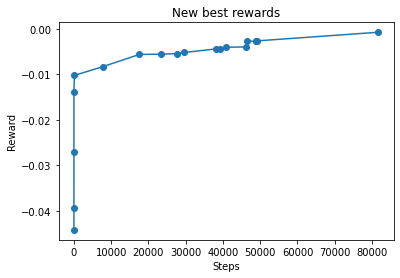

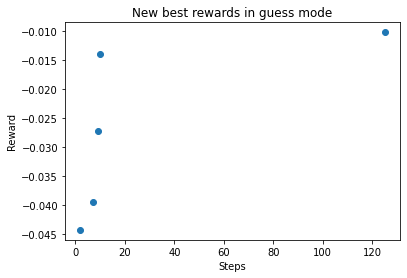

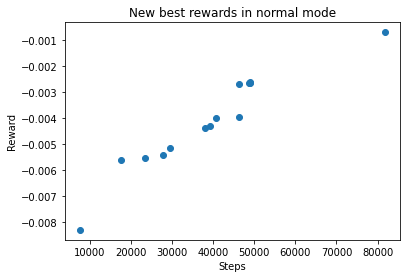

In [23]:
steps=[]
rew=[]
for el in env.improv_hist:
        steps.append(el[0])
        rew.append(el[1])
        
plt.plot(steps,rew, '-o')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('New best rewards')
plt.show()

min_index=len(rew)
for i,step in enumerate(steps):
        if step>guess_steps:
                min_index=i
                break
                
plt.plot(steps[:min_index],rew[:min_index], '-o')
plt.title('New best rewards in guess mode')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()
plt.plot(steps[min_index:],rew[min_index:])
plt.title('New best rewards in normal mode')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

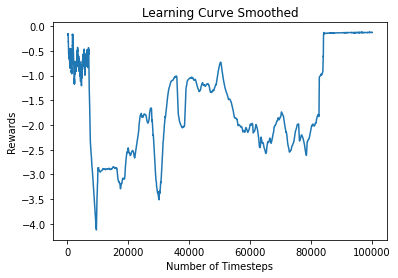

In [22]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, start=0, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = results_plotter.ts2xy(results_plotter.load_results(log_folder), 'timesteps')
    x=x[start:]
    y=y[start:]
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
    
plot_results(log_dir)
#plot_results(log_dir, start=guess_steps) #Plot only results after guess mode